In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_images_from_folders(data_dir, img_size=(64, 64)):
    faces_data = []  
    labels = []      
    label_dict = {}  
    current_label = 0  

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for person_name in os.listdir(data_dir):
        person_dir = os.path.join(data_dir, person_name)
        if os.path.isdir(person_dir):  
            label_dict[person_name] = current_label  
            for image_name in os.listdir(person_dir):
                image_path = os.path.join(person_dir, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
                if image is not None:
                    faces = face_cascade.detectMultiScale(image, scaleFactor=1.3, minNeighbors=5)
                    if len(faces) > 0:
                        (x, y, w, h) = faces[0]
                        face = image[y:y+h, x:x+w]
                        resized_face = cv2.resize(face, img_size)
                        faces_data.append(resized_face)
                        labels.append(current_label)
            current_label += 1  

    faces_data = np.array(faces_data, dtype=np.float32) / 255.0  # Normalize
    faces_data = np.expand_dims(faces_data, axis=-1)  # Add channel dimension

    return faces_data, np.array(labels), label_dict

# Load data
data_dir = "data"
faces_data, labels, label_dict = load_images_from_folders(data_dir)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(faces_data, labels, test_size=0.2, random_state=42)

# Print dataset shape
print("X_train shape:", X_train.shape)  # Should be (N, 64, 64, 1)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Pass label_dict to the model script
num_classes = len(label_dict)


X_train shape: (36, 64, 64, 1)
y_train shape: (36,)
X_test shape: (10, 64, 64, 1)
y_test shape: (10,)


In [49]:
print(label_dict)

{'abdillahi': 0, 'bashir': 1, 'biihi': 2, 'jiir': 3, 'yusuf': 4}


In [50]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Flatten the images (SVM requires 1D feature vectors)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Shape (32, 4096)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)      # Shape (9, 4096)

# Train an SVM model (Linear kernel works well for small datasets)
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_flattened, y_train)
import joblib

# Save the trained SVM model
joblib.dump(svm_model, 'svm_face_recognition.pkl')
print("Model saved as 'svm_face_recognition.pkl'")


# Make predictions
y_pred_svm = svm_model.predict(X_test_flattened)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Test Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print(classification_report(y_test, y_pred_svm, target_names=list(label_dict.keys())))


Model saved as 'svm_face_recognition.pkl'
SVM Test Accuracy: 100.00%
              precision    recall  f1-score   support

   abdillahi       1.00      1.00      1.00         2
      bashir       1.00      1.00      1.00         2
       biihi       1.00      1.00      1.00         2
        jiir       1.00      1.00      1.00         1
       yusuf       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



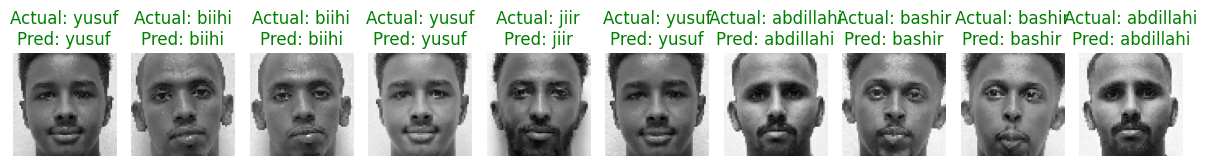

In [46]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_svm_predictions(X_test, y_test, y_pred, label_dict, num_samples=10):
    reverse_label_dict = {v: k for k, v in label_dict.items()}  # Convert labels back to names

    plt.figure(figsize=(12, 5))
    for i in range(min(num_samples, len(X_test))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_test[i].reshape(64, 64), cmap='gray')  # Reshape back to 64x64
        actual_label = reverse_label_dict[y_test[i]]
        predicted_label = reverse_label_dict[y_pred[i]]
        
        # Color text based on correct or incorrect predictions
        color = "green" if actual_label == predicted_label else "red"
        plt.title(f"Actual: {actual_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Call function to visualize predictions
visualize_svm_predictions(X_test, y_test, y_pred_svm, label_dict)


In [47]:
import cv2
import numpy as np

# Load pre-trained face detection model (Haar cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Reverse label dictionary (map numbers to names)
reverse_label_dict = {v: k for k, v in label_dict.items()}

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6, minSize=(60, 60))

    for (x, y, w, h) in faces:
        # Extract face and resize to match training data
        face = gray[y:y + h, x:x + w]
        face_resized = cv2.resize(face, (64, 64))
        
        # Normalize and flatten
        face_normalized = face_resized / 255.0
        face_flattened = face_normalized.reshape(1, -1)

        # Predict with SVM
        probabilities = svm_model.predict_proba(face_flattened)[0]
        max_prob = max(probabilities)
        prediction = svm_model.predict(face_flattened)[0]

        predicted_label = reverse_label_dict[prediction] if max_prob >= 0.5 else "Unknown"

        # Draw rectangle & label
        color = (0, 255, 0) if predicted_label != "Unknown" else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow("Face Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
